# Taller 4
Nombre: Rommel Rivera

Compruebe gráficamente la solución de los siguientes ejercicios:
- (0,1),(1,5),(2,3)
- (0,−5),(1,−4),(2,3)
- (0,−1),(1,1),(2,5),(3,2)

Para cada uno de los ejercicios anteriores, resuelva los splines cúbicos de frontera condicionada con B0=1 para todos los valores de B1∈R Realice una animación de la variación de los splines cúbicos al variar B1 Realice una animación al mover el punto x1, y1


Generando gráfico estático de los tres ejercicios...


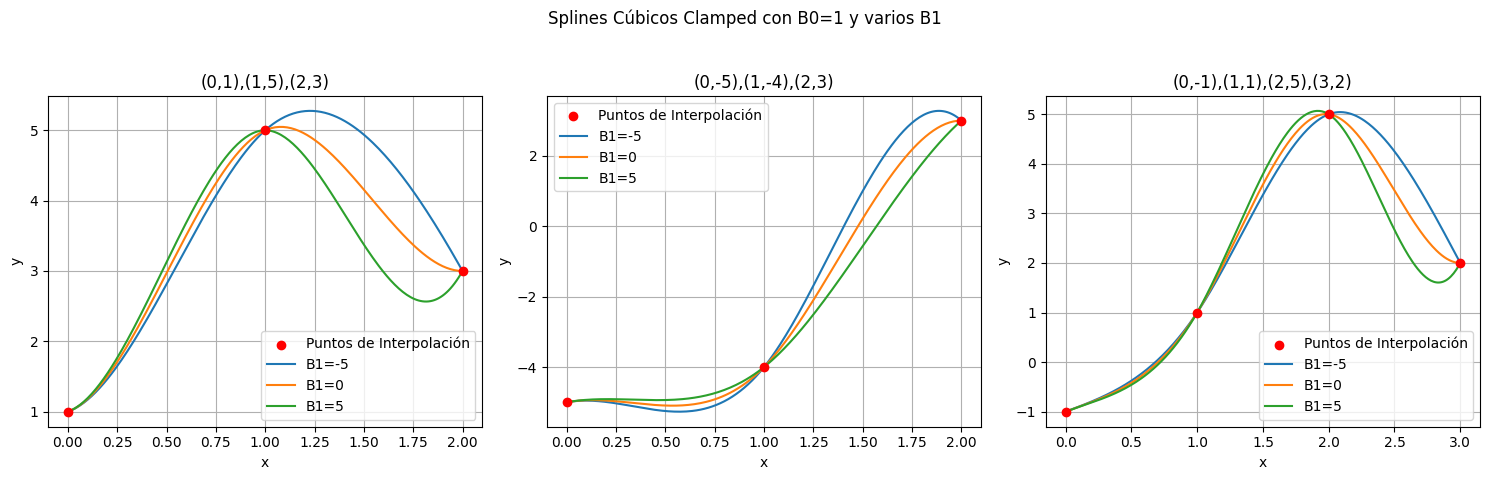


Generando primera animación: Variación de B1...


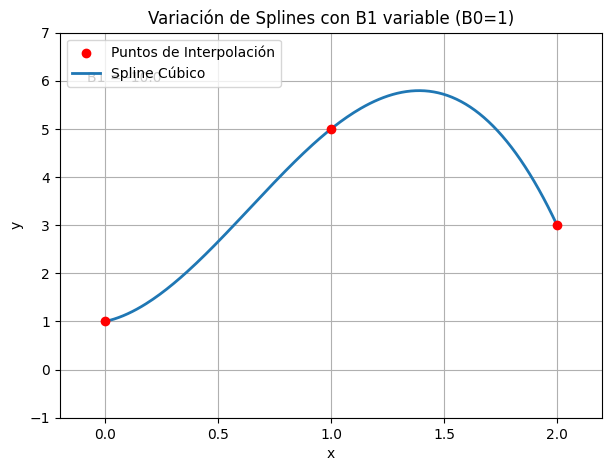


Generando segunda animación: Movimiento del punto central...


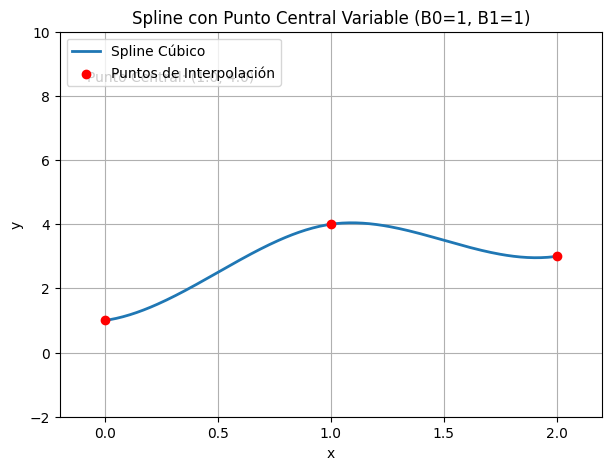

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# import sympy as sym # Not strictly needed for plotting, but used for symbolic output if desired

# --- 1. Numerical Solver for Plotting/Animation ---
def clamped_spline_coeffs(x, y, fp0, fpn):
    """
    Calculates the coefficients (a, b, c, d) for a clamped cubic spline
    given data points (x, y) and first derivatives at the boundaries (fp0, fpn).
    """
    n = len(x) - 1
    h = np.diff(x)  # h_i = x_{i+1} - x_i
    
    # Initialize arrays for the tridiagonal system
    alpha = np.zeros(n + 1)
    l = np.zeros(n + 1)
    u = np.zeros(n + 1)
    z = np.zeros(n + 1)
    
    # Calculate alpha values (modified for clamped boundary conditions)
    alpha[0] = 3 * (y[1] - y[0]) / h[0] - 3 * fp0
    alpha[n] = 3 * fpn - 3 * (y[n] - y[n-1]) / h[n-1]
    
    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (y[i+1] - y[i]) - (3 / h[i-1]) * (y[i] - y[i-1])
        
    # Solve tridiagonal system for c coefficients (actually 2c_i in some notations)
    l[0] = 2 * h[0]
    u[0] = 0.5
    z[0] = alpha[0] / l[0]
    
    for i in range(1, n):
        l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * u[i-1]
        u[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]
        
    l[n] = h[n-1] * (2 - u[n-1])
    z[n] = (alpha[n] - h[n-1] * z[n-1]) / l[n]
    
    # Back substitution to find c, then b and d
    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)
    a = y[:-1] # a_j = y_j
    
    c[n] = z[n] # c_n
    
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j+1]
        b[j] = (y[j+1] - y[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3 * h[j])
        
    return a, b, c[:-1], d # c[:-1] because c_n is not used in the spline segment S_n-1

def get_spline_points(x_nodes, y_nodes, fp0, fpn, num_points=100):
    """
    Generates x and y coordinates for plotting the spline curve.
    """
    a, b, c, d = clamped_spline_coeffs(x_nodes, y_nodes, fp0, fpn)
    x_plot = []
    y_plot = []
    
    for j in range(len(a)): # Iterate over each spline segment
        xs = np.linspace(x_nodes[j], x_nodes[j+1], num_points)
        dx = xs - x_nodes[j]
        # S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3
        ys = a[j] + b[j]*dx + c[j]*dx**2 + d[j]*dx**3
        x_plot.extend(xs)
        y_plot.extend(ys)
        
    return np.array(x_plot), np.array(y_plot)

# --- 2. Static Graphs for the 3 Exercises ---
datasets = [
    (np.array([0., 1., 2.]), np.array([1., 5., 3.])),
    (np.array([0., 1., 2.]), np.array([-5., -4., 3.])),
    (np.array([0., 1., 2., 3.]), np.array([-1., 1., 5., 2.]))
]

fig_static, axes_static = plt.subplots(1, 3, figsize=(15, 5))
titles = ["(0,1),(1,5),(2,3)", "(0,-5),(1,-4),(2,3)", "(0,-1),(1,1),(2,5),(3,2)"]

B0 = 1 # Fixed boundary derivative at x_0
B1_values = [-5, 0, 5] # Different boundary derivatives at x_n for static plot

print("Generando gráfico estático de los tres ejercicios...")
for i, (ax, (x, y)) in enumerate(zip(axes_static, datasets)):
    ax.scatter(x, y, color='red', zorder=5, label='Puntos de Interpolación')
    for b1 in B1_values:
        xp, yp = get_spline_points(x, y, B0, b1)
        ax.plot(xp, yp, label=f'B1={b1}')
    ax.set_title(titles[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)

plt.suptitle(f'Splines Cúbicos Clamped con B0={B0} y varios B1')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show() # Display the static plot

# --- 3. Animations ---

# Animation 1: Varying B1 for Dataset 1
print("\nGenerando primera animación: Variación de B1...")
fig_anim1, ax_anim1 = plt.subplots(figsize=(7, 5))
x1_data, y1_data = datasets[0] # Use the first dataset for this animation
ax_anim1.scatter(x1_data, y1_data, color='red', zorder=5, label='Puntos de Interpolación')
ax_anim1.set_xlim(x1_data[0] - 0.2, x1_data[-1] + 0.2)
ax_anim1.set_ylim(min(y1_data) - 2, max(y1_data) + 2) # Adjust y-limits for good visualization
ax_anim1.grid(True)
ax_anim1.set_title(f"Variación de Splines con B1 variable (B0={B0})")
ax_anim1.set_xlabel('x')
ax_anim1.set_ylabel('y')

line1, = ax_anim1.plot([], [], lw=2, label='Spline Cúbico')
text1 = ax_anim1.text(0.05, 0.9, '', transform=ax_anim1.transAxes, fontsize=10, verticalalignment='top')
ax_anim1.legend(loc='upper left')

def update_b1(frame):
    # Vary B1 from -10 to 10
    b1_current = -10 + frame * (20 / 40) # 40 frames for 20 unit range
    xp, yp = get_spline_points(x1_data, y1_data, B0, b1_current)
    line1.set_data(xp, yp)
    text1.set_text(f'B1 = {b1_current:.1f}')
    return line1, text1,

# Create the animation
anim1 = FuncAnimation(fig_anim1, update_b1, frames=41, interval=100, blit=True, repeat=True)
plt.show() # Display animation 1

# Animation 2: Moving Point (x1, y1) for Dataset 1
print("\nGenerando segunda animación: Movimiento del punto central...")
fig_anim2, ax_anim2 = plt.subplots(figsize=(7, 5))
# For this animation, fix the x-coordinates and end y-coordinates
x_fixed_nodes = np.array([0., 1., 2.])
y_fixed_ends = np.array([1., 3.]) # y0 and y2 are fixed from the first dataset

# Fixed boundary derivatives for this animation
fixed_B0 = 1
fixed_B1 = 1

ax_anim2.set_xlim(x_fixed_nodes[0] - 0.2, x_fixed_nodes[-1] + 0.2)
ax_anim2.set_ylim(-2, 10) # Set a wider y-range to accommodate point movement
ax_anim2.grid(True)
ax_anim2.set_title(f"Spline con Punto Central Variable (B0={fixed_B0}, B1={fixed_B1})")
ax_anim2.set_xlabel('x')
ax_anim2.set_ylabel('y')

line2, = ax_anim2.plot([], [], lw=2, label='Spline Cúbico')
# Scatter plot for the points, with the middle point dynamic
scat2 = ax_anim2.scatter([], [], color='red', zorder=5, label='Puntos de Interpolación')
text2 = ax_anim2.text(0.05, 0.9, '', transform=ax_anim2.transAxes, fontsize=10, verticalalignment='top')
ax_anim2.legend(loc='upper left')

def update_point(frame):
    # Oscillate middle y-coordinate (y_1)
    # Range from 0 to 8, with initial at 5.
    mid_y_current = 4 + 4 * np.sin(frame * (2 * np.pi / 60)) # Cycle through y=0 to y=8 over 60 frames
    curr_y_nodes = np.array([y_fixed_ends[0], mid_y_current, y_fixed_ends[1]])
    
    xp, yp = get_spline_points(x_fixed_nodes, curr_y_nodes, fixed_B0, fixed_B1)
    
    line2.set_data(xp, yp)
    scat2.set_offsets(np.c_[x_fixed_nodes, curr_y_nodes]) # Update scatter plot points
    text2.set_text(f'Punto Central: (1.0, {mid_y_current:.1f})')
    return line2, scat2, text2

# Create the animation
anim2 = FuncAnimation(fig_anim2, update_point, frames=60, interval=75, blit=True, repeat=True)
plt.show() # Display animation 2


Link al repositorio: https://github.com/RommelRam/Metodos-Numericos.git